In [1]:
!pip install pandas numpy matplotlib opencv-python tqdm scikit-image scikit-learn ipython tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 60.9 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
from IPython.display import Image, display

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [4]:
import tensorflow as tf
!nvidia-smi


print(tf.__version__)

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth enabled.")
    except RuntimeError as e:
        print(e)





Fri Nov 29 09:34:01 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [5]:
im_width = 256
im_height = 256

image_filename_train = []

mask_files = glob(pathname=r'/content/drive/MyDrive/Brain MRI Segmentation/lgg-mri-segmentation/kaggle_3m/*/*_mask*')

for i in mask_files:
    image_filename_train.append(i.replace('_mask',''))
print(image_filename_train[:10])
len(image_filename_train)

['/content/drive/MyDrive/Brain MRI Segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8563_19981209/TCGA_HT_8563_19981209_13.tif', '/content/drive/MyDrive/Brain MRI Segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8563_19981209/TCGA_HT_8563_19981209_10.tif', '/content/drive/MyDrive/Brain MRI Segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8563_19981209/TCGA_HT_8563_19981209_7.tif', '/content/drive/MyDrive/Brain MRI Segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8563_19981209/TCGA_HT_8563_19981209_15.tif', '/content/drive/MyDrive/Brain MRI Segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8563_19981209/TCGA_HT_8563_19981209_16.tif', '/content/drive/MyDrive/Brain MRI Segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8563_19981209/TCGA_HT_8563_19981209_18.tif', '/content/drive/MyDrive/Brain MRI Segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8563_19981209/TCGA_HT_8563_19981209_4.tif', '/content/drive/MyDrive/Brain MRI Segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_H

3929

In [6]:
def plot_from_img_path(rows, columns, list_img_path, list_mask_path):
    fig = plt.figure(figsize  = (12,12))
    for i in range(1, rows * columns + 1):
        fig.add_subplot(rows, columns, i)
        img_path = list_img_path[i]
        mask_path = list_mask_path[i]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path)
        plt.imshow(image)
        plt.imshow(mask, alpha=0.4)
    plt.show()

In [7]:
df = pd.DataFrame(data = {'image_filename_train': image_filename_train, 'mask': mask_files})
df_train, df_test = train_test_split(df, test_size = 0.05)
df_train, df_val = train_test_split(df_train, test_size = 0.05)

In [8]:
print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

(3545, 2)
(187, 2)
(197, 2)


In [9]:

import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K

# Normalize images and binarize masks
def normalize_and_diagnose(img, mask):
    img = img / 255.0
    mask = (mask > 0.5).astype(np.float32)
    return img, mask

def dice_coefficients(y_true, y_pred, smooth=100):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)
    intersection = K.sum(y_true_flatten * y_pred_flatten)
    union = K.sum(y_true_flatten) + K.sum(y_pred_flatten)
    return (2 * intersection + smooth) / (union + smooth)

def dice_coefficients_loss(y_true, y_pred, smooth=100):
    return -dice_coefficients(y_true, y_pred, smooth)


def iou(y_true, y_pred, smooth=100):
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true + y_pred)
    iou = (intersection + smooth) / (union - intersection + smooth)
    return iou

# Jaccard distance (1 - IoU)
def jaccard_distance(y_true, y_pred):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)
    return -iou(y_true_flatten, y_pred_flatten)

# Train generator for loading images and masks
def train_generator(
    data_frame,
    batch_size,
    augmentation_dict,
    image_color_mode="rgb",
    mask_color_mode="grayscale",
    image_save_prefix="image",
    mask_save_prefix="mask",
    save_to_dir=None,
    target_size=(256, 256),
    seed=1,
):
    image_datagen = ImageDataGenerator(**augmentation_dict)
    mask_datagen = ImageDataGenerator(**augmentation_dict)

    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col="image_filename_train",
        class_mode=None,
        color_mode=image_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=image_save_prefix,
        seed=seed,
    )

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col="mask",
        class_mode=None,
        color_mode=mask_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=mask_save_prefix,
        seed=seed,
    )

    # Final return Tuple after image Normalization and Diagnostics
    for img, mask in zip(image_generator, mask_generator):
        img, mask = normalize_and_diagnose(img, mask)
        yield img, mask




In [ ]:
display(Image(filename='Unet_Architecture.png'))

FileNotFoundError: [Errno 2] No such file or directory: 'Unet_Architecture.png'

In [10]:
def unet(input_size=(im_width, im_height, 3)):

    inputs = Input(input_size)

    # First DownConvolution / Encoder Leg will begin, so start with Conv2D
    conv1 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(inputs)
    bn1 = Activation("relu")(conv1)
    conv1 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation("relu")(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)
    # First DownSampling
    conv2 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(pool1)
    bn2 = Activation("relu")(conv2)
    conv2 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation("relu")(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)
    #Second DownSampling
    conv3 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(pool2)
    bn3 = Activation("relu")(conv3)
    conv3 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation("relu")(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)
    # Third DownSampling
    conv4 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(pool3)
    bn4 = Activation("relu")(conv4)
    conv4 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation("relu")(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = Conv2D(filters=1024, kernel_size=(3, 3), padding="same")(pool4)
    bn5 = Activation("relu")(conv5)
    conv5 = Conv2D(filters=1024, kernel_size=(3, 3), padding="same")(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation("relu")(bn5)

    up6 = concatenate([Conv2DTranspose(512, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn5), conv4], axis=3)
    """ After every concatenation we again apply two consecutive regular convolutions so that the model can learn to assemble a more precise output """
    conv6 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(up6)
    bn6 = Activation("relu")(conv6)
    conv6 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation("relu")(bn6)

    up7 = concatenate([Conv2DTranspose(256, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn6),conv3], axis=3)
    conv7 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(up7)
    bn7 = Activation("relu")(conv7)
    conv7 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation("relu")(bn7)

    up8 = concatenate([Conv2DTranspose(128, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn7),conv2], axis=3)
    conv8 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(up8)
    bn8 = Activation("relu")(conv8)
    conv8 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation("relu")(bn8)

    up9 = concatenate([Conv2DTranspose(64, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn8),conv1],axis=3)
    conv9 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(up9)
    bn9 = Activation("relu")(conv9)
    conv9 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation("relu")(bn9)

    conv10 = Conv2D(filters=1, kernel_size=(1, 1), activation="sigmoid")(bn9)

    return Model(inputs=[inputs], outputs=[conv10])

In [11]:
from tensorflow.keras.optimizers import Adam

EPOCHS = 30
BATCH_SIZE = 32
learning_rate = 1e-4

train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')
train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_args,
                                target_size=(im_height, im_width))

test_gener = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))

model = unet(input_size=(im_height, im_width, 3))



# decay_rate = learning_rate / EPOCHS

# opt = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=False)
# model.compile(optimizer=opt, loss=dice_coefficients_loss, metrics=["binary_accuracy", iou, dice_coefficients])

opt = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)

# Compile the model
model.compile(
    optimizer=opt,
    loss=dice_coefficients_loss,
    metrics=["binary_accuracy", iou, dice_coefficients]
)

# callbacks = [ModelCheckpoint('unet_brain_mri_seg.hdf5', verbose=1, save_best_only=True)]
callbacks = [
    ModelCheckpoint(
        'unet_brain_mri_seg.keras',  # Use .keras extension
        verbose=1,
        save_best_only=True,
        save_weights_only=False,  # Ensures the entire model is saved, not just weights
        monitor='val_loss',  # Monitor validation loss to save the best model
        mode='min'  # Save model when validation loss decreases
    )
]


# history = model.fit(train_gen,
#                     steps_per_epoch=len(df_train) / BATCH_SIZE,
#                     epochs=EPOCHS,
#                     callbacks=callbacks,
#                     validation_data = test_gener,
#                     validation_steps=len(df_val) / BATCH_SIZE)

history = model.fit(
    train_gen,
    steps_per_epoch=int(len(df_train) / BATCH_SIZE),
    epochs=EPOCHS,
    callbacks=callbacks,
    validation_data=test_gener,
    validation_steps=int(len(df_val) / BATCH_SIZE)
)


Found 3545 validated image filenames.
Found 3545 validated image filenames.
Epoch 1/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 44s/step - binary_accuracy: 0.8895 - dice_coefficients: 0.0987 - iou: 0.0534 - loss: -0.0987 Found 187 validated image filenames.
Found 187 validated image filenames.

Epoch 1: val_loss improved from inf to -0.02768, saving model to unet_brain_mri_seg.keras
110/110 ━━━━━━━━━━━━━━━━━━━━ 5129s 46s/step - binary_accuracy: 0.8900 - dice_coefficients: 0.0991 - iou: 0.0536 - loss: -0.0991 - val_binary_accuracy: 0.9869 - val_dice_coefficients: 0.0277 - val_iou: 0.0141 - val_loss: -0.0277
Epoch 2/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - binary_accuracy: 0.9846 - dice_coefficients: 0.2129 - iou: 0.1217 - loss: -0.2132
Epoch 2: val_loss did not improve from -0.02768
110/110 ━━━━━━━━━━━━━━━━━━━━ 304s 2s/step - binary_accuracy: 0.9847 - dice_coefficients: 0.2131 - iou: 0.1218 - loss: -0.2134 - val_binary_accuracy: 0.9874 - val_dice_coefficients: 0.0259 - val_iou: 0.0134 - val_

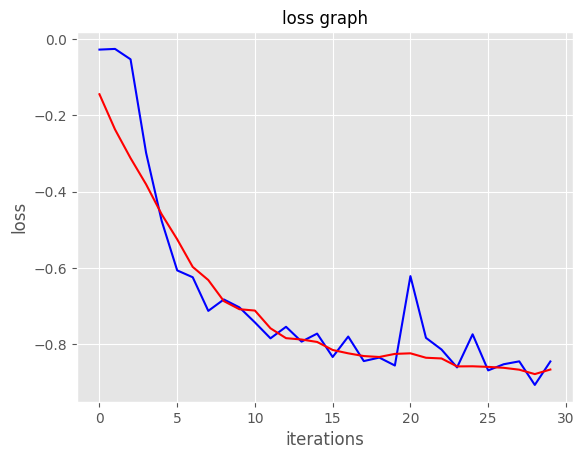

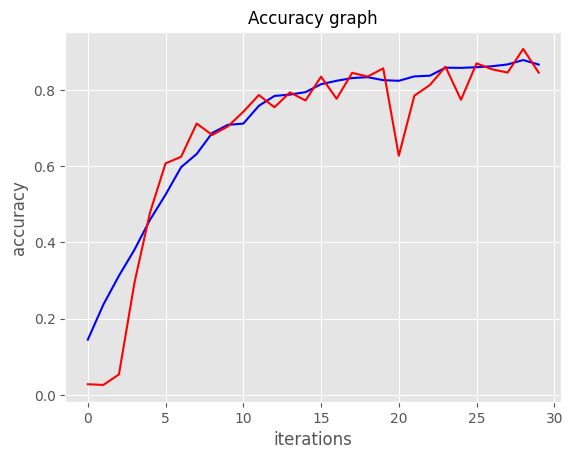

In [13]:
history_post_training = history.history

train_dice_coeff_list = history_post_training['dice_coefficients']
test_dice_coeff_list = history_post_training['val_dice_coefficients']

train_jaccard_list = history_post_training['iou']
test_jaccard_list = history_post_training['val_iou']

train_loss_list = history_post_training['loss']
test_loss_list = history_post_training['val_loss']

plt.figure(1)
plt.plot(test_loss_list, 'b-')
plt.plot(train_loss_list, 'r-')

plt.xlabel('iterations')
plt.ylabel('loss')
plt.title('loss graph', fontsize=12)

plt.figure(2)
plt.plot(train_dice_coeff_list, 'b-')
plt.plot(test_dice_coeff_list, 'r-')

plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.title('Accuracy graph', fontsize=12)
plt.show()

In [15]:
model = load_model('unet_brain_mri_seg.hdf5', custom_objects={'dice_coef_loss': dice_coefficients_loss, 'iou': iou, 'dice_coef': dice_coefficients})

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'unet_brain_mri_seg.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [17]:
test_gen = train_generator(df_test, BATCH_SIZE, dict(), target_size=(im_height,im_width))

results = model.evaluate(test_gen, steps = int(len(df_test)/BATCH_SIZE))
print('Test Loss', results[0])
print('Test IOU', results[1])
print('Test Dice Coeff', results[2])

Found 197 validated image filenames.
Found 197 validated image filenames.
6/6 ━━━━━━━━━━━━━━━━━━━━ 183s 36s/step - binary_accuracy: 0.9974 - dice_coefficients: 0.8133 - iou: 0.6890 - loss: -0.8133
Test Loss -0.8367978930473328
Test IOU 0.9972115159034729
Test Dice Coeff 0.7232141494750977


In [ ]:
for i in range(20):
    index = np.random.randint(1, len(df_test.index))
    img = cv2.imread(df_test['image_filename_train'].iloc[index])
    img = cv2.resize(img, (im_height,im_width))
    img = img/255
    img = img[np.newaxis, : ,:, :]
    pred_img = model.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1, 3, 1)
    plt.imshow(np.squeeze(img))
    plt.title("Original Image")
    plt.subplot(1, 3, 2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask'].iloc[index])))
    plt.title("Original Mask")
    plt.subplot(1, 3, 3)
    plt.imshow(np.squeeze(pred_img) > 0.5)
    plt.title("Prediction")
    plt.show()